*Material adapted from:  MOOC "Scalable Machine Learning", EdX. *

January, 2016

#EVALUATION FUNCTION AND BASELINE MODEL

This notebook has two main goals: choose a baseline model and choose an evaluation function.

The process of selecting model and function are explained throughout the notebook. To sum it up:

* **Evaluation function** = LogLoss (lower values are better)

$$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ 

* **Baseline model chosen** = always predict value 0.06998 (average) instead of most frequent (0): 

    Baseline Logloss (predicted = 0, calculated by function) = 0.17725
    Baseline Logloss (predicted = 0.06998, calculated by function) = 0.04170

###IMPORT PACKAGES

Let's import packages used in this notebook:

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [2]:
#VISUALIZATION
%matplotlib inline
import matplotlib.pyplot as plt

###IMPORT DATA AND CHOOSE A BASELINE MODEL.

*"A very simple yet natural baseline model is one where we always make the same prediction independent of the given datapoint, setting the predicted value equal to the fraction of training points that correspond to click-through events (i.e., where the label is one). Compute this value (which is simply the mean of the training labels), and then use it to compute the training log loss for the baseline model. The log loss for multiple observations is the mean of the individual log loss values.¶" *(source: "Scalable Machine Learning", EdX)

So in order to calculate the predicted value for the baseline model, we will use the known outcome (stored at *"outcome.csv"*)

So first, we import the file "outcome.csv", stored inside a folder named "DATA":

*\DATA\outcome.csv*

In [3]:
#Use panda to import csv
df = pd.read_csv('DATA/outcome.csv', sep=';')
print df.columns.values

#Column 0 includes ad_ref. Column 1 refers to outcome (0= no click, 1=click)
df.columns.values

['0' '0.1']


array(['0', '0.1'], dtype=object)

In [4]:
print df["0.1"][1:5]

1    0
2    0
3    0
4    0
Name: 0.1, dtype: int64


The dataframe "df" has two columns. The second one "0.1" contains the outcome values (1 = clicked, 0 = not-clicked).

In [5]:
print df["0.1"].shape

(681313L,)


There are 681313 cases. 

#####Which predicted value to use?

We have two options: to use the most frequent value or to use the average value.

####A. Baseline predicted value = most frequent 
Let's check the label values:

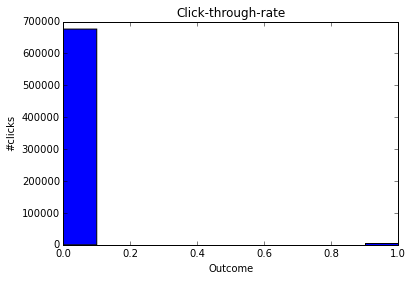

In [6]:
#Let's plot the outcome values to see wich value is more common, 0 (no-click) or 1 (click).

plt.hist(df["0.1"])
plt.title("Click-through-rate")
plt.xlabel("Outcome")
plt.ylabel("#clicks")
plt.show()

In [7]:
#Most of values are 0. Baseline will be to predict outcome=0
#Let's add a column to df called "predict" that will have the predicted value (0)
df["predict1"]=0

Let's see how this model performs. First the confussion matrix:

In [8]:
#EVALUATE MODEL
#Let's see the confussion matrix:

y_pred = df["predict1"]
y_true = df["0.1"]

'''#print model score
print model.score(y_pred,y_true)'''

confusion_matrix(y_true, y_pred)

array([[676545,      0],
       [  4768,      0]])

And calculate performance metrics (accuracy, sensitivity, specificity...)

In [9]:
#EVALUATE ACCURACY, SENSITIVITY, SPECIFICITY...

TP = 0.
TN = 676545.
FP = 0.
FN = 4768.

print "BASELINE MODEL SCORE"
print "True Positive Rate (Sensitivity): ",TP/(TP+FN)
print "False Positive Rate:", FP/(FP+TN)
print "True Negative Rate (Specificity): ",TN/(TN+FP)
print "Positive Predictive Value (Precision): ", 0
print "Negative Predictive Value: ", TN/(FN+TN)
print "Score (Accuracy): ",(TP + TN)/(TP + TN + FP + FN)

BASELINE MODEL SCORE
True Positive Rate (Sensitivity):  0.0
False Positive Rate: 0.0
True Negative Rate (Specificity):  1.0
Positive Predictive Value (Precision):  0
Negative Predictive Value:  0.993001748095
Score (Accuracy):  0.993001748095


The accuracy of the baseline model is already of 99.3%. Seems like accuracy is a poor meassure fo quality of model.

At click-through-rate competitions usually Submissions are evaluated using the Logarithmic Loss (smaller is better).
https://www.kaggle.com/c/avazu-ctr-prediction/details/evaluation

Let's keep this idea for later. Once we calculate average baseline model we will choose between both depending on performance scores.

#####B. BASELINE PREDICTED VALUE = AVERAGE
From now, let's calculate the predicted value in case we used average:


In [10]:
#BASELINE PREDICTED VALUE WHILE USING MOST FREQUENT:

df["predict2"]=df["0.1"].mean() 
print "The predicted value for the baseline is ", df["0.1"].mean() 

The predicted value for the baseline is  0.00699825190478



###LOGARITHMIC LOSS TO CALCULATE MODEL PERFORMANCE** (Log loss) **
(source: "Scalable Machine Learning" MOOC)

Log loss is defined as: $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ 
where $ \scriptsize p$ is a probability between 0 and 1 and $ \scriptsize y$ is a label of either 0 or 1. 
Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction (it is also the criterion used in the [Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)).  

Problem is, 0 and 1 values don't work well with log. So the trick is to use a "epsilon" value (very small) to avoid pure zeros as well as pure 1.

In [11]:
'''
FUNCTION LOGLOSS AS IMPLEMENTED BY KAGGLE:
SOURCE: https://www.kaggle.com/wiki/LogarithmicLoss
import scipy as sp
def llfun(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = sum(ll)
    ll = ll * -1.0/len(act)
    return ll
'''

'''Implementation of logloss by 4IDIOTS:
https://github.com/guestwalk/kaggle-avazu/tree/master/ensemble/util
'''    

#EPSILON USED: 
epsilon = 10e-12
total = 681313.0

#BASELINE CASE, PREDICTED VALUE = 0, computed by hand:
#676545 cases in which true value = 0 and predicted = 0 -> loss += 676545*log(1)=0
#4768 cases in which true value = 1 and predicted = 0 -> loss += 4768*log(0)
#TOTAL of 681313

import scipy as sp


loss1 = 676545.0*sp.log(1.0-epsilon)+4768.0*sp.log(0.0+epsilon)
LogLoss1 =(round(-loss1/total, 6))
print 'Baseline Logloss (predicted = 0, calculated by hand) = {0:.5f}\n'.format(LogLoss1)

#BASELINE CASE, PREDICTED VALUE = 0.00699825190478, computed by hand:
#676545 cases in which true value = 0 and predicted = 0.00699825190478 
#-> loss += 676545*log(1-0.00699825190478)=0
#4768 cases in which true value = 1 and predicted = 0.00699825190478 
#-> loss += 4768*log(0.00699825190478)
#TOTAL of 681313

loss2 = 676545.0*sp.log(1.0-0.00699825190478)+4768.0*sp.log(0.0+0.00699825190478)
LogLoss2 =(round(-loss2/total, 6))
print 'Baseline Logloss (predicted = 0.00699825190478, calculated by hand) = {0:.5f}\n'.format(LogLoss2)

#Using the Logloss function, lower values are better
print "COMMENT:"
print "Lower performance values are better."
print "So using the LogLoss function to evaluate performance, we use as baseline model"
print "the one that predicts an outcome equal to the average (0.06998)"

Baseline Logloss (predicted = 0, calculated by hand) = 0.17725

Baseline Logloss (predicted = 0.00699825190478, calculated by hand) = 0.04170

COMMENT:
Lower performance values are better.
So using the LogLoss function to evaluate performance, we use as baseline model
the one that predicts an outcome equal to the average (0.06998)


Now we are going to code the logloss as a function.

Function *computeTotalLogLoss(pred, true, epsylon)*

Parameters:

pred - predicted value

true - true outcome/value

epsylon - value used to avoid pure zeros/ones. By default, epsilon = 10e-12

In [12]:
#Let's implement it in python:
#First, the part where we calculate loss from p,y:
import scipy as sp

def computeLogLoss(p, y, epsylon=10e-12):
    """
    Source: "Scalable Machine Learning", EdX
    Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """

    if p == 0.0: p = epsilon
    if p == 1.0: p = 1.0-epsilon
    
    if y == 1: loss = -sp.log(p)
    if y == 0: loss = -sp.log(1.0-p)
    
    return loss

def computeTotalLogLoss(pred,true, epsilon=10e-12):

    loss, total = 0.0, 0.0
    for i in range(0,len(pred)):
        loss += computeLogLoss(pred[i],true[i], epsilon)
        total += 1.0

    if total == 0:
        return('nan')
    else:
        return(round(loss/total, 10))

#BASELINE CASE: COMPUTED USING FUNCTIONS
#Let's compute our baseline model logarithmic loss:

#a) predicted = 0
y_true = df["0.1"]
y_pred1 = df["predict1"]

epsilon = 10e-12
ModelLoss = computeTotalLogLoss(y_pred1, y_true, epsilon)
print 'Baseline Logloss (predicted = 0, calculated by function) = {0:.5f}\n'.format(ModelLoss)

#a) predicted = 0
y_true = df["0.1"]
y_pred2 = df["predict2"]
    
epsilon = 10e-12
ModelLoss = computeTotalLogLoss(y_pred2, y_true, epsilon)
print 'Baseline Logloss (predicted = 0.06998, calculated by function) = {0:.5f}\n'.format(ModelLoss)

print "Performance scores match the ones calculated by hand."

Baseline Logloss (predicted = 0, calculated by function) = 0.17725

Baseline Logloss (predicted = 0.06998, calculated by function) = 0.04170

Performance scores match the ones calculated by hand.


###LOGLOSS USING SCI-KIT LEARN

Sci-kit has this function implemented. For more information, see:

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/classification.py





In [13]:
#Let's see if the code solution matches sklearn.metrics.log_loss
y_pred1array = np.array(y_pred1)
y_pred2array = np.array(y_pred2)
y_truearray = np.array(y_true)

#BASELINE CASE: COMPUTED USING SKLEARN
#Let's compute our baseline model logarithmic loss:

#a) predicted = 0
ModelLoss = log_loss(y_truearray, y_pred1array, eps=epsilon, normalize=True, sample_weight=None)
print 'Baseline Logloss (predicted = 0, calculated by sklearn) = {0:.5f}\n'.format(ModelLoss)

#b) predicted = 0.06998
ModelLoss = log_loss(y_truearray, y_pred2array, eps=epsilon, normalize=True, sample_weight=None)
print 'Baseline Logloss (predicted = 0.06998, calculated by sklearn) = {0:.5f}\n'.format(ModelLoss)

print "Performance scores match the ones calculated by code."

Baseline Logloss (predicted = 0, calculated by sklearn) = 0.17725

Baseline Logloss (predicted = 0.06998, calculated by sklearn) = 0.04170

Performance scores match the ones calculated by code.


###Weighted LogLoss Function

Usually businesses have different costs associated to False Positives (predicting a click when there isn't one) and False Negatives (predicting non-click when there is one). Typically False Positives are more costly.

Now we will try to include this idea to our LogLoss Function:

 $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases}   -\ weight1 * log (p) & \text{if } y = 1 \\\ -\ weight0 * log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ 

where $ \scriptsize p$ is a probability between 0 and 1, $ \scriptsize y$ is a label of either 0 or 1, weight0 is cost of a False Positive (by default = 1,0) and weight1 is cost of a False Negative (by default = 1,0). A bigger value of weight penalizes more.

Let's code this in python:



In [14]:
def computeLogLossWeighted(p, y, weight0 = 1.0, weight1 = 1.0, epsylon=10e-12):
    """
    Source: "Scalable Machine Learning", EdX
    Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.
        weight0 (float): cost of predicting 1 when real value is 0
        weight1 (float): cost of predicting 0 when real value is 1

    Returns:
        float: The log loss value.
    """

    if p == 0.0: p = epsilon
    if p == 1.0: p = 1.0-epsilon
    
    if y == 1: loss = - weight1 * sp.log(p)
    if y == 0: loss = - weight0 * sp.log(1.0-p)
    
    return loss

def computeTotalLogLossWeighted(pred,true, weight0 = 1.0, weight1 = 1.0, epsilon=10e-12):

    loss, total = 0.0, 0.0
    for i in range(0,len(pred)):
        loss += computeLogLossWeighted(pred[i],true[i], weight0, weight1, epsilon)
        total += 1.0

    if total == 0:
        return('nan')
    else:
        return(round(loss/total, 10))
    
#BASELINE CASE: COMPUTED USING FUNCTIONS
#Let's compute our baseline model logarithmic loss:

#a) predicted = 0
y_true = df["0.1"]
y_pred1 = df["predict1"]
weight0 = 1.0
weight1 = 1.0

epsilon = 10e-12
ModelLoss = computeTotalLogLossWeighted(y_pred1, y_true, weight0, weight1, epsilon)
print 'Baseline Logloss Weighted(predicted = 0, calculated by function) = {0:.5f}\n'.format(ModelLoss)

#b) predicted = 0
y_true = df["0.1"]
y_pred2 = df["predict2"]
    
epsilon = 10e-12
ModelLoss = computeTotalLogLossWeighted(y_pred2, y_true, weight0, weight1, epsilon)
print 'Baseline Logloss Weighted (predicted = 0.06998, calculated by function) = {0:.5f}\n'.format(ModelLoss)

print "Performance scores match the ones calculated by standard formula."

Baseline Logloss Weighted(predicted = 0, calculated by function) = 0.17725

Baseline Logloss Weighted (predicted = 0.06998, calculated by function) = 0.04170

Performance scores match the ones calculated by standard formula.


####What happens if we change the cost of a False Positive and False Negative?

To try the weighted feature, let's imagine a possible scenario:... let's say each click costs 0.5€, and if the customer actually buys something, the corresponding benefit will be 5€ per purchase.

Then, the "economic" score of this model would be *benefit - cost*:

- Benefit = 5€ * real positives 

- Cost = 0.5€ *(false negatives + real positives)

So...
False positives (predicting a click when there is not) will cost 0.5€
False negatives (predicting non-click when there would be) will "cost" the company 4.5€ (will not gain 5€ - 0.5€).

So in this scenario...
- weight0 = 0.5€ 
- weight1 = 4.5€

It means that for the company is more important to predict well clicks than non-clicks. 

In [37]:
weight0 = 0.5
weight1 = 4.5

#a) predicted = 0
y_true = df["0.1"]
y_pred1 = df["predict1"]
epsilon = 10e-12
ModelLoss1 = computeTotalLogLossWeighted(y_pred1, y_true, weight0, weight1, epsilon)
print 'Baseline Logloss Weighted(predicted = 0, calculated by function) = {0:.5f}\n'.format(ModelLoss1)


#b) predicted = 0.06998
y_true = df["0.1"]
y_pred2 = df["predict2"]
epsilon = 10e-12
ModelLoss2 = computeTotalLogLossWeighted(y_pred2, y_true, weight0, weight1, epsilon)
print 'Baseline Logloss Weighted (predicted = 0.06998, calculated by function) = {0:.5f}\n'.format(ModelLoss2)


Baseline Logloss Weighted(predicted = 0, calculated by function) = 0.79765

Baseline Logloss Weighted (predicted = 0.06998, calculated by function) = 0.15975



### AREA UNDER THE CURVE

Let's visually see their performance using `sklearn.metrics.auc` (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)



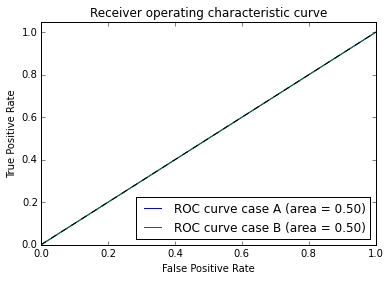

In [34]:

y_pred1array = np.array(y_pred1)
y_pred2array = np.array(y_pred2)
y_truearray = np.array(y_true)

#AUC score
#a) predicted = 0
fpr1, tpr1, _ = roc_curve(y_truearray, y_pred1array)
roc_auc1 = auc(fpr1, tpr1)

#b) predicted = 0.06998
fpr2, tpr2, _ = roc_curve(y_truearray, y_pred2array)
roc_auc2 = auc(fpr2, tpr2)


# Plot ROC curve 
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve case A (area = %0.2f)' % roc_auc1)
plt.plot(fpr1, tpr1, label='ROC curve case B (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

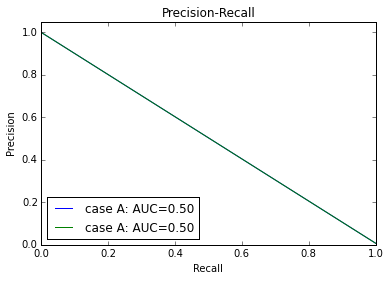

In [36]:
#AUCprc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_pred1array = np.array(y_pred1)
y_pred2array = np.array(y_pred2)
y_truearray = np.array(y_true)


#a) predicted = 0
precision1, recall1, threshold1 = precision_recall_curve(y_truearray, y_pred1array)
average_precision1 = average_precision_score(y_truearray, y_pred1array)

#b) predicted = 0.06998
precision2, recall2, threshold2 = precision_recall_curve(y_truearray, y_pred2array)
average_precision2 = average_precision_score(y_truearray, y_pred2array)

# Plot curve
plt.clf()
plt.plot(recall1, precision1, label='case A: AUC={0:0.2f}'.format(average_precision1))
plt.plot(recall2, precision2, label='case A: AUC={0:0.2f}'.format(average_precision2))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.show()
          